# Define the pdfs

We need to ensure that the pdfs are properly truncated

In [30]:
import scipy
from scipy.stats import crystalball, truncexpon, uniform, truncnorm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#define the parameters
mu = 3
sigma = 0.3
beta = 1
m = 1.4
f = 0.6
lmbda = 0.3
mu_b = 0
sigma_b = 2.5

#define upper and lower limits
X_ulim = 5
X_llim = 0
Y_ulim = 10
Y_llim = 0

def g_s(X):
    return crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(X_ulim, beta, m, mu, sigma) - crystalball.cdf(X_llim, beta, m, mu, sigma))

def h_s(Y):
    trunc_b = (Y_ulim - Y_llim)*lmbda
    return truncexpon.pdf(Y, trunc_b, Y_llim, 1/lmbda)

def g_b(X):
    return uniform.pdf(X, X_llim, X_ulim)

def h_b(Y):
    a = (mu_b - Y_llim)/sigma_b
    b = (Y_ulim - mu_b)/sigma_b
    return truncnorm.pdf(Y, a, b, mu_b, sigma_b)

Plot these pdfs to visualise what they look like

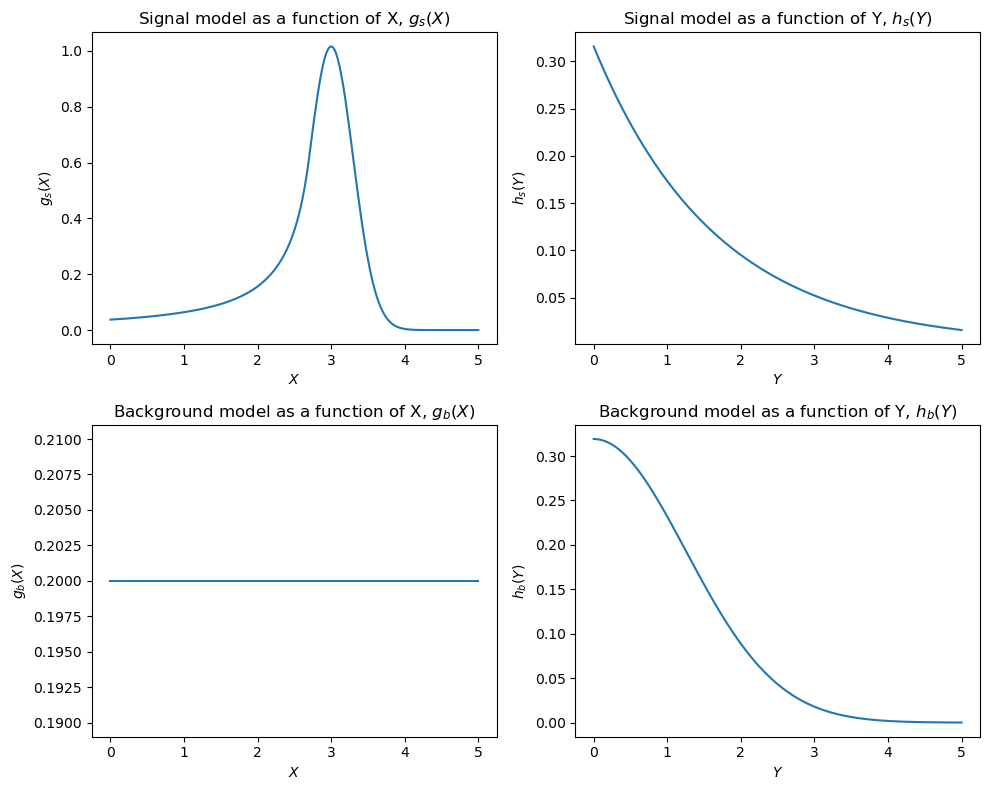

In [29]:
# Create a 2x2 grid of plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8)) 

x = np.linspace(0, 5, 200)
y = np.linspace(0, 10, 200)

#plot the signal for X
ax[0,0].plot(x, g_s(x))
ax[0,0].set_title(r'Signal model as a function of X, $g_s(X)$')
ax[0,0].set_ylabel(r'$g_s(X)$')
ax[0,0].set_xlabel(r'$X$')

#plot the signal for Y
ax[0,1].plot(x, h_s(y))
ax[0,1].set_title(r'Signal model as a function of Y, $h_s(Y)$')
ax[0,1].set_ylabel(r'$h_s(Y)$')
ax[0,1].set_xlabel(r'$Y$')

#plot the background for X
ax[1,0].plot(x, g_b(x))
ax[1,0].set_title(r'Background model as a function of X, $g_b(X)$')
ax[1,0].set_ylabel(r'$g_b(X)$')
ax[1,0].set_xlabel(r'$X$')

#plot the background for Y
ax[1,1].plot(x, h_b(y))
ax[1,1].set_title(r'Background model as a function of Y, $h_b(Y)$')
ax[1,1].set_ylabel(r'$h_b(Y)$')
ax[1,1].set_xlabel(r'$Y$')

plt.tight_layout()


Numeric integration to show that they are normalised

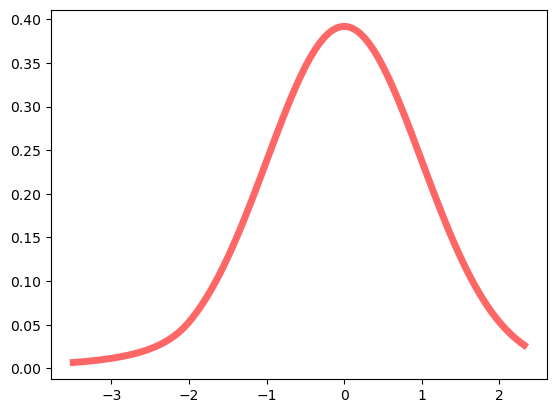

In [5]:
beta, m = 2, 3

fig, ax = plt.subplots(1, 1)
x = np.linspace(crystalball.ppf(0.01, beta, m),
                crystalball.ppf(0.99, beta, m), 100)
ax.plot(x, crystalball.pdf(x, beta, m),
       'r-', lw=5, alpha=0.6, label='crystalball pdf')